In [1]:
import math ; pi=math.pi
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import healpy as hp
import time

In [2]:
# Import PySSC module
import PySSC

In [3]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
# Redshift bins
zstakes = np.arange(0.2,1.6,step=0.1)
zbins = zstakes[:-1]+(zstakes[1:]-zstakes[:-1])/2
zmin = np.min(zstakes) ; zmax = np.max(zstakes)
# Kernels
nz       = 500
z_arr    = np.linspace(0,2,num=nz+1)[1:] # Redshifts must be > 0
nbins_T   = len(zstakes)-1
kernels_T = np.zeros((nbins_T,nz))
for i in range(nbins_T):
    zminbin = zstakes[i] ; zmaxbin = zstakes[i+1] ; Dz = zmaxbin-zminbin
    for iz in range(nz):
        z = z_arr[iz]
        if ((z>zminbin) and (z<=zmaxbin)):
            kernels_T[i,iz] = 1/Dz
print(zstakes)

[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]


## Comparison of Sij matrix for full sky and partial sky Sij for full-sky mask

In [6]:
# full sky Sij
t0 = time.process_time()
print('Full sky Sij')
Sijw_full = PySSC.Sij(z_arr,kernels_T,
                      convention=0,
                      precision=10)
# partial sky Sij with full-sky mask
t1 = time.process_time()
print('Partial sky Sij')
Sijw_part = PySSC.Sij_psky(
    z_arr,kernels_T,
    clmask=None,
    mask='./masks/full_sky_map.fits',
    verbose=True,
    debug=True,
    convention=0,
    precision=10) #long computation
t2 = time.process_time()
print('Sij full sky took: %.1f secs, part sky %.1f secs' %(t1-t0,t2-t1))

Full sky Sij
Partial sky Sij
Using given mask map
f_sky = 1.0000
lmax = 0
Debug: minmax of relative difference Cl_zero vs Cl_XY(ell=0) -3.5138214358387963e-15 9.683259422122226e-15
Debug: fsky,ell,cl_mask 0.999999999906307 [0] [12.56637061]
Debug: Sij computation 6.905599921174415e-06 6.9055999211744156e-06
Sij full sky took: 3.4 secs, part sky 28.1 secs


In [7]:
map_mask = hp.read_map('./masks/full_sky_map.fits')
nside    = hp.pixelfunc.get_nside(map_mask)
lmaxofcl = 2*nside
cl_mask  = hp.anafast(map_mask, lmax=lmaxofcl)

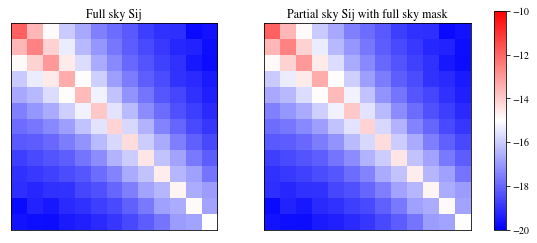

In [8]:
# Plotting the two matrices
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(8,3.5))
im = axes[0].imshow(np.log(abs(Sijw_full)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-10)
im2 = axes[1].imshow(np.log(abs(Sijw_part)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-10)
for ax in axes:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axes[0].set_title('Full sky Sij')
axes[1].set_title('Partial sky Sij with full sky mask')
fig.subplots_adjust(left=0.02,bottom=0.08,top=0.9,wspace=0.002)
cbar_ax = fig.add_axes([0.9, 0.08, 0.02, 0.87])
c_bar=fig.colorbar(im,cax=cbar_ax,fraction=.5)

100.0% of the part sky Sij bins are within 1% of the Sij full sky value


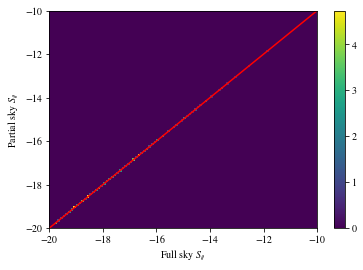

In [9]:
plt.figure()
plt.hist2d(np.log(abs(Sijw_full)).flatten(),np.log(abs(Sijw_part)).flatten(),bins=100,density=True,range=[[-20,-10],[-20,-10]])
plt.plot(np.linspace(-20,-10,100),np.linspace(-20,-10,100),color='r')
plt.xlabel(r'Full sky $S_{ij}$')
plt.ylabel(r'Partial sky $S_{ij}$')
plt.colorbar()

diff = (np.log(abs(Sijw_full)) - np.log(abs(Sijw_part)))/np.log(abs(Sijw_full)) *100
print('%.1f%% of the part sky Sij bins are within 1%% of the Sij full sky value' %(np.sum(diff<=1.)/nbins_T**2 *100))

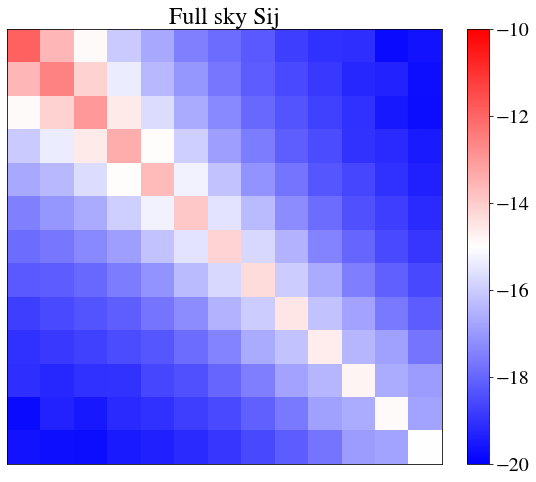

In [10]:
# Plotting the two matrices
fig = plt.figure(figsize=(9,8))
im = plt.imshow(
    np.log(abs(Sijw_full)),
    interpolation='none',
    cmap='bwr',
    extent=[zmin,zmax,zmax,zmin],
    vmin=-20, vmax=-10
)
plt.tick_params(axis='both', which='both',
                bottom=False, left=False,
                labelbottom=False, labelleft=False)
plt.title('Full sky Sij', fontsize=24)
c_bar=fig.colorbar(im, fraction=.05)
c_bar.ax.tick_params(labelsize=20)

## Partial sky Sij for DES mask

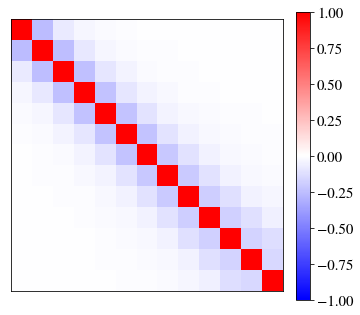

-0.25794761221889334


In [11]:
# Let's now plot the correlation matrix : Sij/sqrt(Sii*Sjj)
#Compute the correlation matrix
correlw_full = np.zeros((nbins_T,nbins_T))
for i in range(nbins_T):
    for j in range(nbins_T):
        correlw_full[i,j] = Sijw_full[i,j] / np.sqrt(Sijw_full[i,i]*Sijw_full[j,j])
#Plot it
fig = plt.figure(figsize=(5.5, 5))
P = plt.imshow(correlw_full, interpolation='none', cmap='bwr', vmin=-1, vmax=1)
plt.xticks([]) ; plt.yticks([])
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
print(correlw_full.min())

In [12]:
t0 = time.process_time()
Sijw_part_DES = PySSC.Sij_psky(z_arr,kernels_T,mask='./masks/DES-mask-simple-ring-1024.fits',verbose=True)
t1 = time.process_time()
print('Computed in %.1f minutes' %((t1-t0)/60))

Using given mask map
f_sky = 0.1207
lmax = 32
Computed in 1.8 minutes


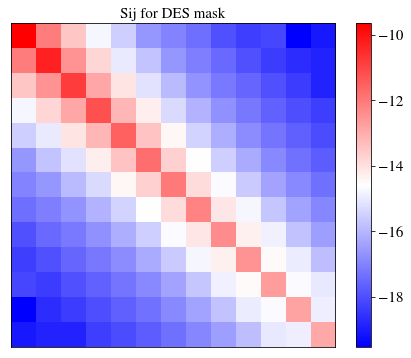

In [13]:
#Plotting
fig = plt.figure(figsize=(6.,5)) 
ax = fig.add_axes([0.05,0.05,0.75,0.9]) 
P = ax.imshow(
    np.log(abs(Sijw_part_DES)),
    interpolation='none', cmap='bwr',
    extent=[zmin,zmax,zmax,zmin]
) 
plt.xticks([]) ; plt.yticks([]) 
ax1 = fig.add_axes([0.85, 0.05, 0.035, 0.9]) 
cbar = plt.colorbar(P,ax1) 
cbar.ax.tick_params(labelsize=15) 
ax.set_title('Sij for DES mask',fontsize=15)

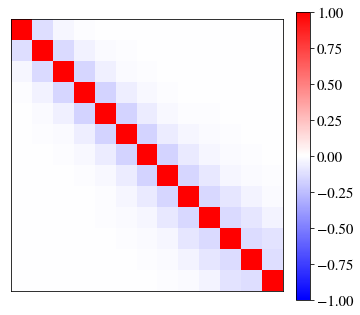

-0.16949293683738742


In [17]:
# Let's now plot the correlation matrix : Sij/sqrt(Sii*Sjj)
#Compute the correlation matrix
correlw_part_DES = np.zeros((nbins_T,nbins_T))
for i in range(nbins_T):
    for j in range(nbins_T):
        correlw_part_DES[i,j] = Sijw_part_DES[i,j] / np.sqrt(Sijw_part_DES[i,i]*Sijw_part_DES[j,j])
#Plot it
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(
    correlw_part_DES,
    interpolation='none',
    cmap='bwr',
    vmin=-1, vmax=1
)
plt.xticks([])
plt.yticks([])
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
print(correlw_part_DES.min())

### Comparison between Sij full sky rescaled by f_sky and partial sky Sij

(13, 13) 13 14
Mean relative difference: 3.88 %
Mean relative difference on the diagonal: 0.32 %


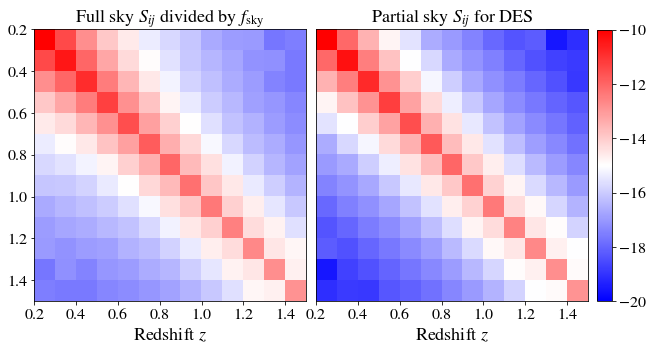

In [15]:
f_sky = 0.1207
print(Sijw_full.shape,nbins_T,len(zstakes))
# Plotting the two matrices
fig,axes=plt.subplots(1,2,figsize=(10,5),gridspec_kw={'wspace':0.02})
im = axes[0].imshow(
    np.log(abs(Sijw_full/f_sky)),
    interpolation='none', cmap='bwr',
    extent=[zmin,zmax,zmax,zmin],
    vmin=-20, vmax=-10
)
im2 = axes[1].imshow(
    np.log(abs(Sijw_part_DES)),
    interpolation='none', cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-10)
axes[0].get_xaxis().set_ticks(zstakes[::2])
axes[0].get_yaxis().set_ticks(zstakes[::2])
axes[1].get_xaxis().set_ticks(zstakes[::2])
axes[1].get_yaxis().set_ticks([])
axes[0].set_title(r'Full sky $S_{ij}$ divided by $f_\mathrm{sky}$',fontsize=18)
axes[1].set_title('Partial sky $S_{ij}$ for DES',fontsize=18)
for ax in axes:
    ax.tick_params(labelsize=16)
    ax.set_xlabel(r'Redshift $z$',fontsize=18)
cbar_ax = fig.add_axes([0.91, 0.124, 0.02, 0.755])
c_bar=fig.colorbar(im,cax=cbar_ax,fraction=1)
c_bar.ax.tick_params(labelsize=16)
#plt.savefig('Comparison_full_partsky_DES.png')

print('Mean relative difference: %.2f %%' %(np.mean(abs((np.log10(abs(Sijw_full/f_sky))-np.log10(abs(Sijw_part_DES)))/np.log10(abs(Sijw_part_DES))*100))))
print('Mean relative difference on the diagonal: %.2f %%' %(np.mean(abs((np.log10(abs(np.diag(Sijw_full)/f_sky))-np.log10(abs(np.diag(Sijw_part_DES))))/np.log10(abs(np.diag(Sijw_part_DES)))*100))))

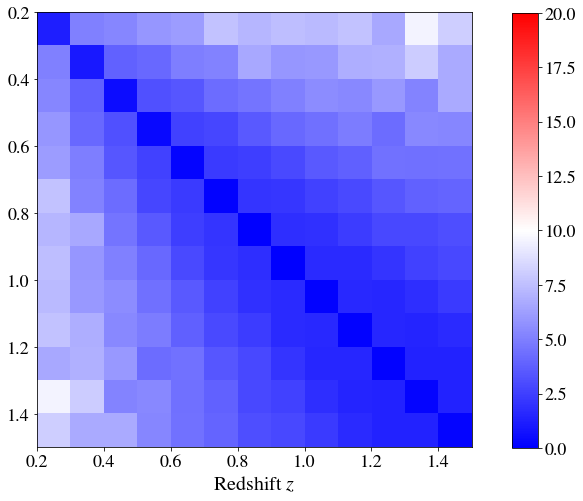

In [16]:
f_sky = 0.1207
# Plotting the two matrices
fig = plt.figure(figsize=(9, 8))
im = plt.imshow(
    abs((np.log10(abs(Sijw_full/f_sky))-np.log10(abs(Sijw_part_DES)))/np.log10(abs(Sijw_part_DES))*100),
    interpolation='none', cmap='bwr',
    extent=[zmin,zmax,zmax,zmin],
    vmin=0, vmax=20
)
plt.xticks(zstakes[::2])
plt.yticks(zstakes[::2])
plt.tick_params(labelsize=18)
plt.xlabel(r'Redshift $z$', fontsize=20)
cbar_ax = fig.add_axes([0.91, 0.124, 0.04, 0.755])
c_bar=fig.colorbar(im, cax=cbar_ax, fraction=1)
c_bar.ax.tick_params(labelsize=18)
# plt.savefig('Comparison_full_partsky_DES.png')


100.0% of the part sky Sij bins are within 1% of the Sij full sky value


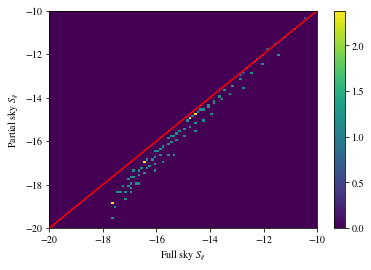

In [18]:
plt.figure()
plt.hist2d(
    np.log(abs(Sijw_full/f_sky)).flatten(),
    np.log(abs(Sijw_part_DES)).flatten(),
    bins=100, density=True,
    range=[[-20,-10],[-20,-10]]
)
plt.plot(np.linspace(-20,-10,100),
         np.linspace(-20,-10,100),
         color='r')
plt.xlabel(r'Full sky $S_{ij}$')
plt.ylabel(r'Partial sky $S_{ij}$')
plt.colorbar()

diff = (np.log(abs(Sijw_full)) - np.log(abs(Sijw_part)))/np.log(abs(Sijw_full)) *100
print('%.1f%% of the part sky Sij bins are within 1%% of the Sij full sky value' %(np.sum(diff<=10.)/nbins_T**2 *100))


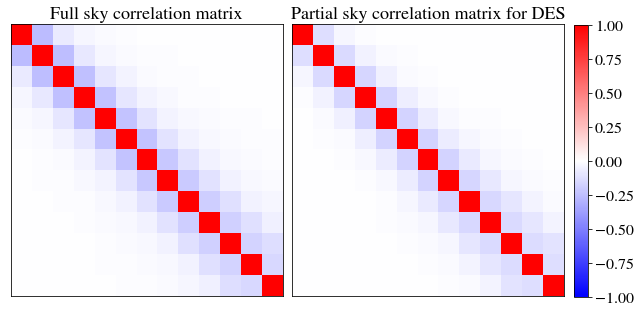

In [19]:
# Plotting the two matrices
fig,axes=plt.subplots(1,2,figsize=(10,5),gridspec_kw={'wspace':0.02})
im = axes[0].imshow(
    correlw_full,
    interpolation='none',
    cmap='bwr',
    extent=[zmin,zmax,zmax,zmin],
    vmin=-1, vmax=1
)
im2 = axes[1].imshow(
    correlw_part_DES,
    interpolation='none',
    cmap='bwr',
    extent=[zmin,zmax,zmax,zmin],
    vmin=-1, vmax=1
)
for ax in axes:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axes[0].set_title(r'Full sky correlation matrix',fontsize=18)
axes[1].set_title('Partial sky correlation matrix for DES',fontsize=18)
cbar_ax = fig.add_axes([0.91, 0.124, 0.02, 0.755])
c_bar=fig.colorbar(im,cax=cbar_ax,fraction=1)
c_bar.ax.tick_params(labelsize=16)

## Partial sky Sij for Euclid mask

In [20]:
t0 = time.process_time()
Sijw_part_Euclid = PySSC.Sij_psky(z_arr, kernels_T,
                                  mask='./masks/Euclid_map_WIDE_SURVEY.fits',
                                  verbose=True)
t1 = time.process_time()
print('Computed in %.1f minutes' %((t1-t0)/60))

Using given mask map
f_sky = 0.3762
lmax = 27
Computed in 1.3 minutes


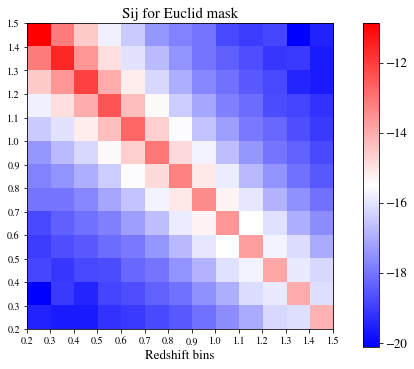

In [21]:
#Plotting
fig = plt.figure(figsize=(6.,5)) 
ax = fig.add_axes([0.05,0.1,0.75,0.85]) 
P = ax.imshow(np.log(abs(Sijw_part_Euclid)),
              interpolation='none',
              cmap='bwr',
              extent=(zmin, zmax, zmin, zmax)) 
plt.xlabel(r'Redshift bins',fontsize=13) 
plt.xticks(zstakes) 
plt.yticks(zstakes)
ax1 = fig.add_axes([0.85, 0.05, 0.035, 0.9]) 
cbar = plt.colorbar(P,ax1) 
cbar.ax.tick_params(labelsize=13) 
ax.set_title('Sij for Euclid mask',fontsize=15)

-0.1790324986124151


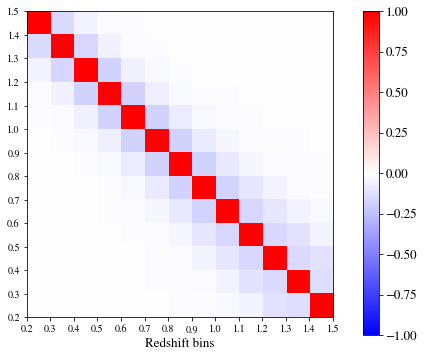

In [22]:
# Let's now plot the correlation matrix : Sij/sqrt(Sii*Sjj)
#Compute the correlation matrix
correlw_part_Euclid = np.zeros((nbins_T,nbins_T))
for i in range(nbins_T):
    for j in range(nbins_T):
        correlw_part_Euclid[i,j] = Sijw_part_Euclid[i,j] / np.sqrt(Sijw_part_Euclid[i,i]*Sijw_part_Euclid[j,j])
#Plot it
fig = plt.figure(figsize=(6,5))
ax = fig.add_axes([0.05,0.1,0.75,0.85]) 
P = ax.imshow(
    correlw_part_Euclid,
    interpolation='none',
    cmap='bwr',
    vmin=-1, vmax=1,
    extent=(zmin,zmax,zmin,zmax)
) 
plt.xlabel(r'Redshift bins', fontsize=13) 
plt.xticks(zstakes) 
plt.yticks(zstakes)
ax1 = fig.add_axes([0.85, 0.05, 0.035, 0.9])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=13)
print(correlw_part_Euclid.min())

## Partial sky Sij for 5 degrees patch

In [23]:
t0 = time.process_time()
Sijw_part_5d = PySSC.Sij_psky(z_arr, kernels_T,
                              mask='./masks/circular-mask_5deg.fits',
                              verbose=True)
t1 = time.process_time()
print('Computed in %.1f minutes' %((t1-t0)/60))

Using given mask map
f_sky = 0.0019
lmax = 136
Computed in 6.8 minutes


Text(0.5, 1.0, 'Sij for 5 deg sky patch')

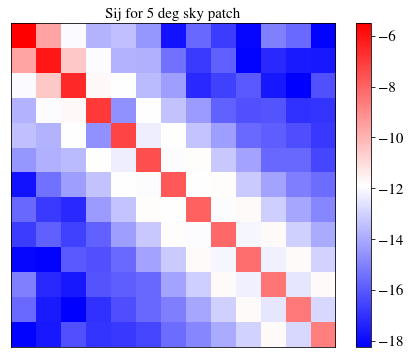

In [24]:
#Plotting
fig = plt.figure(figsize=(6.,5)) 
ax = fig.add_axes([0.05,0.05,0.75,0.9]) 
P = ax.imshow(
    np.log(abs(Sijw_part_5d)),
    interpolation='none',
    cmap='bwr',
    extent=[zmin,zmax,zmax,zmin]
) 
plt.xticks([])
plt.yticks([]) 
ax1 = fig.add_axes([0.85, 0.05, 0.035, 0.9]) 
cbar = plt.colorbar(P,ax1) 
cbar.ax.tick_params(labelsize=15) 
ax.set_title('Sij for 5 deg sky patch', fontsize=15)

(13,) 14


Text(0, 0.5, '$S_{ij}(z_1=0.5,z_2)$')

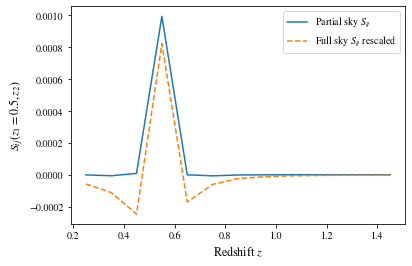

In [25]:
ii = 3
f_sky = 0.0019
print(Sijw_full[ii,:].shape,len(zstakes))
plt.figure()
plt.plot(zbins,Sijw_part_5d[ii,:],label=r'Partial sky $S_{ij}$')
plt.plot(zbins,Sijw_full[ii,:]/f_sky,label=r'Full sky $S_{ij}$ rescaled',ls='--')
plt.legend()
plt.xlabel(r'Redshift $z$',fontsize=12)
plt.ylabel(r'$S_{ij}(z_1=%.1f,z_2)$' %(zstakes[ii]),fontsize=12)

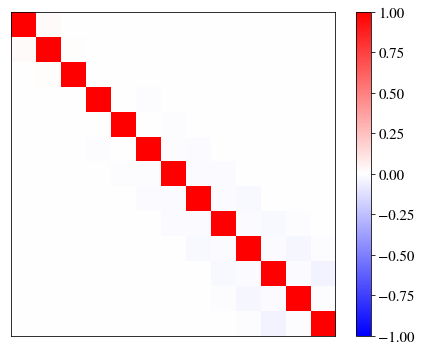

-0.04097380981621653


In [26]:
# Let's now plot the correlation matrix : Sij/sqrt(Sii*Sjj)
#Compute the correlation matrix
nzbins          = len(zstakes) - 1
correlw_part_5d = np.zeros((nbins_T,nbins_T))
for i in range(nbins_T):
    for j in range(nbins_T):
        correlw_part_5d[i,j] = Sijw_part_5d[i,j] / np.sqrt(Sijw_part_5d[i,i]*Sijw_part_5d[j,j])
#Plot it
fig = plt.figure(figsize=(6,5))
ax = fig.add_axes([0.05,0.05,0.75,0.9])
P = ax.imshow(correlw_part_5d,interpolation='none',cmap='bwr',vmin=-1,vmax=1)
plt.xticks([]) ; plt.yticks([])
ax1 = fig.add_axes([0.85, 0.05, 0.035, 0.9]) 
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
print(correlw_part_5d.min())

# Most general case: Sijkl

### Comparison of results for full sky

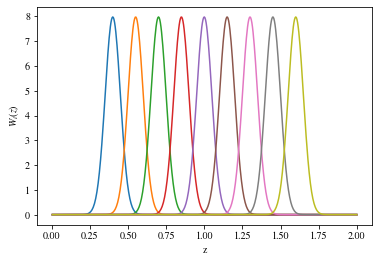

In [28]:
#Top-hat kernels have no interest here, since the cross-spectra would be basically zero
#So we go for Gaussian kernels
sigmaz    = 0.05
zcenter_G = [0.4,0.55,0.7,0.85,1.,1.15,1.3,1.45,1.6]
nbins_G   = len(zcenter_G)
kernels_G = np.zeros((nbins_G,nz))
for i in range(nbins_G):
    kernels_G[i,:] = np.exp(-(z_arr-zcenter_G[i])**2/(2*sigmaz**2)) / np.sqrt(2*pi*sigmaz**2)

# Plot kernels
for i in range(nbins_G):
    plt.plot(z_arr, kernels_G[i,:], lw=1.5)
plt.xlabel('z') ; plt.ylabel('$W_i(z)$')
plt.show()

In [29]:
#Top-hat kernels functions have no interest here, since the cross-spectra would be basically zero
#So we go for Gaussian kernels
t0 = time.process_time()
Sijkl_full = PySSC.Sijkl(z_arr,kernels_G)
t1 = time.process_time()

Sijkl_psky = PySSC.Sijkl_psky(z_arr,kernels_G,clmask=None,mask='./masks/full_sky_map.fits',verbose=True)
t2 = time.process_time()
print('Sij full sky took: %.1f secs, part sky %.1f secs' %(t1-t0,t2-t1))

/tmp/ipykernel_275312/1040114006.py:4: DeprecationWarning: The Sijkl functions are now deprecated. Please move to using Sij by feeding the kernel products, see the documentation at https://pyssc.readthedocs.io/en/latest/notebooks/Main-Examples.html#General-case-with-cross-spectra
  Sijkl_full = PySSC.Sijkl(z_arr,kernels_G)
/tmp/ipykernel_275312/1040114006.py:7: DeprecationWarning: The Sijkl functions are now deprecated. Please move to using Sij by feeding the kernel products, see the documentation at https://pyssc.readthedocs.io/en/latest/notebooks/Main-Examples.html#General-case-with-cross-spectra
  Sijkl_psky = PySSC.Sijkl_psky(z_arr,kernels_G,clmask=None,mask='./masks/full_sky_map.fits',verbose=True)


Using given mask map
f_sky = 1.0000
lmax = 0
Sij full sky took: 4.2 secs, part sky 27.8 secs


In [30]:
#Build indexing of pairs of redshift bins
npairs_G = (nbins_G*(nbins_G+1))//2
pairs_G  = np.zeros((2,npairs_G),dtype=int)
count       = 0
for ibin in range(nbins_G):
    for jbin in range(ibin,nbins_G):
        pairs_G[0,count] = ibin
        pairs_G[1,count] = jbin
        count +=1
#Recast Sijkl as a matrix of pairs, for later visualisation
Sijkl_full_recast = np.zeros((npairs_G,npairs_G))
Sijkl_psky_recast = np.zeros((npairs_G,npairs_G))
for ipair in range(npairs_G):
    ibin = pairs_G[0,ipair]
    jbin = pairs_G[1,ipair]
    for jpair in range(npairs_G):
        kbin = pairs_G[0,jpair]
        lbin = pairs_G[1,jpair]
        Sijkl_full_recast[ipair,jpair] = Sijkl_full[ibin,jbin,kbin,lbin]
        Sijkl_psky_recast[ipair,jpair] = Sijkl_psky[ibin,jbin,kbin,lbin]

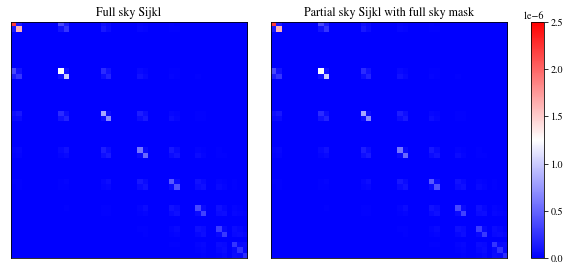

In [31]:
# Plotting the two matrices
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(9,4))
im = axes[0].imshow(
    abs(Sijkl_full_recast),
    interpolation='none',
    cmap='bwr',
    extent=[zmin,zmax,zmax,zmin],
    vmin=0, vmax=2.5e-6
)
im2 = axes[1].imshow(
    abs(Sijkl_psky_recast),
    interpolation='none',
    cmap='bwr',
    extent=[zmin,zmax,zmax,zmin],
    vmin=0, vmax=2.5e-6)
for ax in axes:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axes[0].set_title('Full sky Sijkl')
axes[1].set_title('Partial sky Sijkl with full sky mask')
fig.subplots_adjust(left=0.03,bottom=0.08,top=0.9,right=0.83,wspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.08, 0.02, 0.82])
c_bar=fig.colorbar(im,cax=cbar_ax,fraction=.5)

In [32]:
#Remove pairs of bins with zero covariance
invalid_list         = np.where(np.diag(Sijkl_psky_recast)==0)[0]
Sijkl_psky_recast_valid = np.delete(np.delete(Sijkl_psky_recast,invalid_list,0),invalid_list,1)
nvalid               = Sijkl_psky_recast_valid.shape[0]
print(nvalid)
invalid_list         = np.where(np.diag(Sijkl_full_recast)==0)[0]
Sijkl_full_recast_valid = np.delete(np.delete(Sijkl_full_recast,invalid_list,0),invalid_list,1)
nvalid               = Sijkl_full_recast_valid.shape[0]
print(nvalid)

17
17


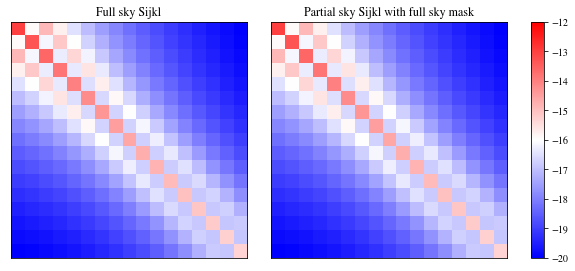

In [33]:
# Plotting the two matrices
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(9,4))
im = axes[0].imshow(np.log(abs(Sijkl_full_recast_valid)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-12)
im2 = axes[1].imshow(np.log(abs(Sijkl_psky_recast_valid)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-12)
for ax in axes:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axes[0].set_title('Full sky Sijkl')
axes[1].set_title('Partial sky Sijkl with full sky mask')
fig.subplots_adjust(left=0.03,bottom=0.08,top=0.9,right=0.83,wspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.08, 0.02, 0.82])
c_bar=fig.colorbar(im,cax=cbar_ax,fraction=.5)

100.0% of the part sky Sij bins are within 1% of the Sij full sky value


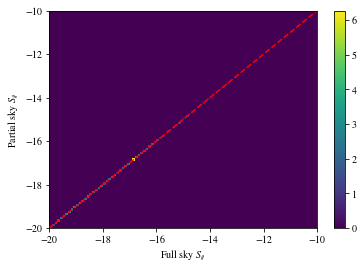

In [34]:
plt.figure()
plt.hist2d(np.log(abs(Sijkl_full_recast_valid)).flatten(),np.log(abs(Sijkl_psky_recast_valid)).flatten(),bins=100,density=True,range=[[-20,-10],[-20,-10]])
plt.plot(np.linspace(-20,-10,100),np.linspace(-20,-10,100),color='r',ls='--')
plt.xlabel(r'Full sky $S_{ij}$')
plt.ylabel(r'Partial sky $S_{ij}$')
plt.colorbar()

diff = (np.log(abs(Sijkl_full_recast_valid)) - np.log(abs(Sijkl_psky_recast_valid)))/np.log(abs(Sijkl_full_recast_valid)) *100
print('%.1f%% of the part sky Sij bins are within 1%% of the Sij full sky value' %(np.sum(diff<=1.)/nvalid**2 *100))

### Example: Partial sky Sijkl with Euclid mask

In [35]:
t0 = time.process_time()
Sijkl_pskyE = PySSC.Sijkl_psky(z_arr,kernels_G,clmask=None,mask='./masks/Euclid_map_WIDE_SURVEY.fits',verbose=True)
t1 = time.process_time()
print('Sij part sky computed in %.1f mins' %((t1-t0)/60))

/tmp/ipykernel_275312/1116555293.py:2: DeprecationWarning: The Sijkl functions are now deprecated. Please move to using Sij by feeding the kernel products, see the documentation at https://pyssc.readthedocs.io/en/latest/notebooks/Main-Examples.html#General-case-with-cross-spectra
  Sijkl_pskyE = PySSC.Sijkl_psky(z_arr,kernels_G,clmask=None,mask='./masks/Euclid_map_WIDE_SURVEY.fits',verbose=True)


Using given mask map
f_sky = 0.3762
lmax = 27
Sij part sky computed in 1.6 mins


In [36]:
#Build indexing of pairs of redshift bins
npairs_G = (nbins_G*(nbins_G+1))//2
pairs_G  = np.zeros((2,npairs_G),dtype=int)
count       = 0
for ibin in range(nbins_G):
    for jbin in range(ibin,nbins_G):
        pairs_G[0,count] = ibin
        pairs_G[1,count] = jbin
        count +=1
#Recast Sijkl as a matrix of pairs, for later visualisation
Sijkl_pskyE_recast = np.zeros((npairs_G,npairs_G))
for ipair in range(npairs_G):
    ibin = pairs_G[0,ipair]
    jbin = pairs_G[1,ipair]
    for jpair in range(npairs_G):
        kbin = pairs_G[0,jpair]
        lbin = pairs_G[1,jpair]
        Sijkl_pskyE_recast[ipair,jpair] = Sijkl_pskyE[ibin,jbin,kbin,lbin]


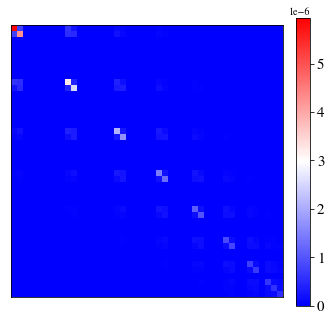

In [37]:
#Plot |Sijkl|
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(abs(Sijkl_pskyE_recast),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)

In [38]:
#Remove pairs of bins with zero covariance
invalid_list         = np.where(np.diag(Sijkl_pskyE_recast)==0)[0]
Sijkl_pskyE_recast_valid = np.delete(np.delete(Sijkl_pskyE_recast,invalid_list,0),invalid_list,1)
nvalid               = Sijkl_pskyE_recast_valid.shape[0]

-0.18525896025233982


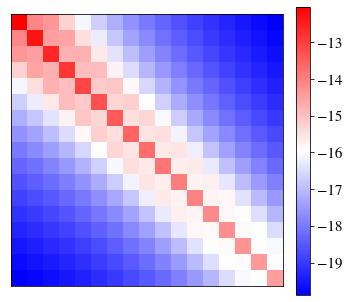

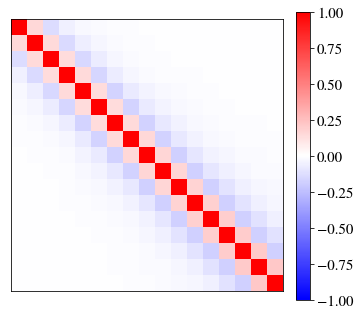

In [40]:
#Plot ln|Sijkl|
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(
    np.log(abs(Sijkl_pskyE_recast_valid)),
    interpolation='none',
    cmap='bwr',
    extent=[zmin,zmax,zmax,zmin]
)
P.axes.tick_params(labelsize=15)
plt.xticks([])
plt.yticks([])
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)

#Second plot the correlation matrix
correl_ijkl_pskyE= np.zeros((nvalid,nvalid))
for i in range(nvalid):
    for j in range(nvalid):
        correl_ijkl_pskyE[i,j] = Sijkl_pskyE_recast_valid[i,j] / np.sqrt(Sijkl_pskyE_recast_valid[i,i]*Sijkl_pskyE_recast_valid[j,j])

fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(
    correl_ijkl_pskyE,
    interpolation='none',
    cmap='bwr',
    vmin=-1, vmax=1,
    extent=[zmin,zmax,zmax,zmin]
)
plt.xticks([]) ; plt.yticks([])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)

print(correl_ijkl_pskyE.min())

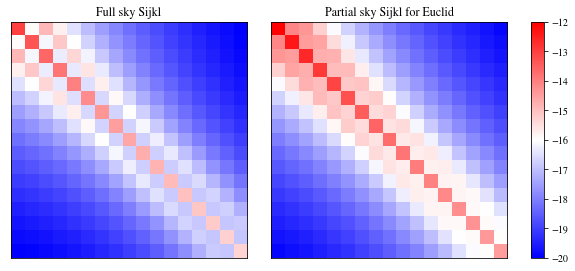

In [41]:
# Compare to full sky
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(9,4))
im = axes[0].imshow(
    np.log(abs(Sijkl_full_recast_valid)),
    interpolation='none',
    cmap='bwr',
    extent=[zmin,zmax,zmax,zmin],
    vmin=-20, vmax=-12
)
im2 = axes[1].imshow(
    np.log(abs(Sijkl_pskyE_recast_valid)),
    interpolation='none',
    cmap='bwr',
    extent=[zmin,zmax,zmax,zmin],
    vmin=-20, vmax=-12
)
for ax in axes:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axes[0].set_title('Full sky Sijkl')
axes[1].set_title('Partial sky Sijkl for Euclid')
fig.subplots_adjust(left=0.03,bottom=0.08,top=0.9,right=0.83,wspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.08, 0.02, 0.82])
c_bar=fig.colorbar(im,cax=cbar_ax,fraction=.5)

Mean ratio of elements of psky to rescaled full sky: 0.71
Mean ratio of diagonal elements of psky to rescaled full sky: 0.94


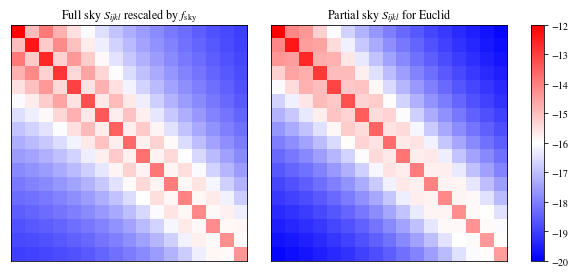

In [42]:
# Compare to full sky rescaled by f_sky
f_sky = 0.3762

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(9,4))
im = axes[0].imshow(np.log(abs(Sijkl_full_recast_valid/f_sky)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-12)
im2 = axes[1].imshow(np.log(abs(Sijkl_pskyE_recast_valid)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-12)
for ax in axes:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axes[0].set_title(r'Full sky $S_{ijkl}$ rescaled by $f_\mathrm{sky}$')
axes[1].set_title(r'Partial sky $S_{ijkl}$ for Euclid')
fig.subplots_adjust(left=0.03,bottom=0.08,top=0.9,right=0.83,wspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.08, 0.02, 0.82])
c_bar=fig.colorbar(im,cax=cbar_ax,fraction=.5)

print('Mean ratio of elements of psky to rescaled full sky: %.2f' %(np.mean(Sijkl_pskyE_recast_valid/(Sijkl_full_recast_valid/f_sky))))
print('Mean ratio of diagonal elements of psky to rescaled full sky: %.2f' %(np.mean(np.diag(Sijkl_pskyE_recast_valid/(Sijkl_full_recast_valid/f_sky)))))

# Euclid redshift bins

In [43]:
prefix_Euclid='./Euclid_files/'

## Photometric bins

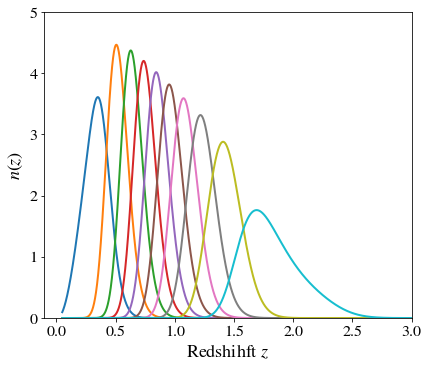

In [44]:
zarr = np.loadtxt(prefix_Euclid+'n_z_without_1_plus_z.dat',unpack=True,usecols=(0))[100:]
kernels = np.loadtxt(prefix_Euclid+'n_z_without_1_plus_z.dat',unpack=True,usecols=(1,2,3,4,5,6,7,8,9,10))[:,100:]
nbins = kernels.shape[0]
zbins = zarr[np.argmax(kernels,axis=1)]
fig = plt.figure(figsize=(6,5))
ax = fig.add_axes([0.1,0.12,0.85,0.85]) 
for u,zbin in enumerate(kernels):
	plt.plot(zarr,zbin,linewidth=2)
plt.xlabel(r'Redshihft $z$',fontsize=18) ; plt.xticks(fontsize=15)
plt.ylabel(r'$n(z)$',fontsize=18)
# plt.legend(frameon='False',loc='best')
plt.xlim([-0.1,3])
plt.ylim(0,5)
plt.tick_params(labelsize=16)
#plt.savefig(prefix_Euclid+'n_z_Euclid_GCphot.png')

In [45]:
# partial sky Sijkl with Euclid mask
t1 = time.process_time()
print('Computing partial sky Sijkl for Euclid...')
Sijkl1 = PySSC.Sijkl_psky(zarr,kernels,clmask=None,mask='./masks/Euclid_map_WIDE_SURVEY.fits') 
t2 = time.process_time()
print('Sij took %.1f mins' %((t2-t1)/60))

Computing partial sky Sijkl for Euclid...


/tmp/ipykernel_275312/52515289.py:4: DeprecationWarning: The Sijkl functions are now deprecated. Please move to using Sij by feeding the kernel products, see the documentation at https://pyssc.readthedocs.io/en/latest/notebooks/Main-Examples.html#General-case-with-cross-spectra
  Sijkl1 = PySSC.Sijkl_psky(zarr,kernels,clmask=None,mask='./masks/Euclid_map_WIDE_SURVEY.fits')


Sij took 5.4 mins


55 39


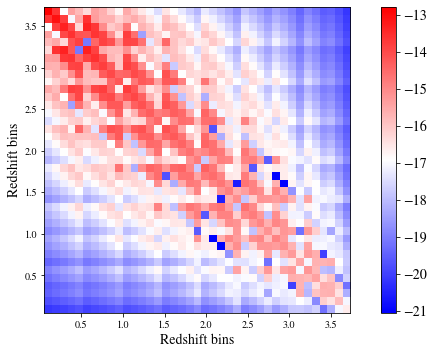

In [46]:
#Build indexing of pairs of redshift bins
npairs = (nbins*(nbins+1))//2
pairs  = np.zeros((2,npairs),dtype=int)
count  = 0
for ibin in range(nbins):
    for jbin in range(ibin,nbins):
        pairs[0,count] = ibin
        pairs[1,count] = jbin
        count +=1
#Recast Sijkl as a matrix of pairs, for later visualisation
Sijkl_psky_recast = np.zeros((npairs,npairs))
for ipair in range(npairs):
    ibin = pairs[0,ipair]
    jbin = pairs[1,ipair]
    for jpair in range(npairs):
        kbin = pairs[0,jpair]
        lbin = pairs[1,jpair]
        Sijkl_psky_recast[ipair,jpair] = Sijkl1[ibin,jbin,kbin,lbin]

#Remove pairs of bins with zero covariance
invalid_list         = np.where(np.diag(Sijkl_psky_recast)==0)[0]
m = np.diag(Sijkl_psky_recast)!=0
Sijkl_psky_recast_valid = np.delete(np.delete(Sijkl_psky_recast,invalid_list,0),invalid_list,1)
nvalid               = Sijkl_psky_recast_valid.shape[0]
print(npairs,nvalid)
# print(invalid_list,np.sum(m))

fig = plt.figure(figsize=(6.,5)) 
ax = fig.add_axes([0.05,0.1,0.75,0.85]) 
P = ax.imshow(np.log(abs(Sijkl_psky_recast_valid)),interpolation='none',cmap='bwr',extent=(np.min(zarr),np.max(zarr),np.min(zarr),np.max(zarr))) 
plt.xlabel(r'Redshift bins',fontsize=14); plt.ylabel(r'Redshift bins',fontsize=14)
# for zbin in zbins:
#     plt.axvline(zbin,color='k')
#     plt.axhline(zbin,color='k')
ax1 = fig.add_axes([0.85, 0.1, 0.035, 0.85]) 
cbar = plt.colorbar(P,ax1) 
cbar.ax.tick_params(labelsize=14) 
# ax.set_title('Sijkl for Euclid',fontsize=18)

-0.19836329514810153
(39, 39) [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.1 3.2 3.3 3.4
 3.5 3.6 3.7] 0.05 3.7310000000000003
[0.0, 1.0, 2.0, 3.0]


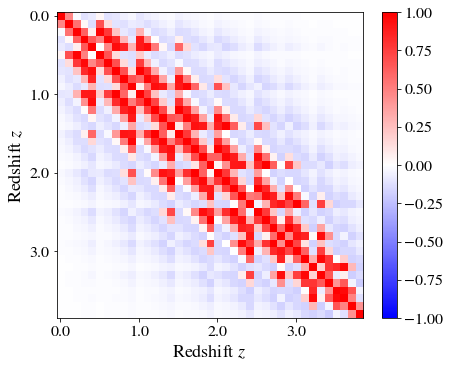

In [47]:
#Second plot the correlation matrix
correl_ijkl_psky= np.zeros((nvalid,nvalid))
for i in range(nvalid):
    for j in range(nvalid):
        correl_ijkl_psky[i,j] = Sijkl_psky_recast_valid[i,j] / np.sqrt(Sijkl_psky_recast_valid[i,i]*Sijkl_psky_recast_valid[j,j])

fig = plt.figure(figsize=(6,5))
ax = fig.add_axes([0.05,0.12,0.8,0.85]) 
# P = ax.imshow(correl_ijkl_psky,interpolation='none',cmap='bwr',vmin=-1,vmax=1,extent=[np.min(zarr),np.max(zarr),np.max(zarr),np.min(zarr)])
P = ax.imshow(correl_ijkl_psky,interpolation='none',cmap='bwr',vmin=-1,vmax=1)
# plt.xticks([]) ; plt.yticks([])
#plt.xlabel(r'Redshift bins',fontsize=14); plt.ylabel(r'Redshift bins',fontsize=14) 
#plt.title('Correlation matrix for Euclid',fontsize=18)
# ax2 = ax.twinx()
# for zbin in kernels:
#     ax2.plot(zarr,zbin,color='k',lw=.8)
# P.axes.tick_params(labelsize=15)
zticks = np.round(np.linspace(np.min(zarr),np.max(zarr),correl_ijkl_psky.shape[0]),decimals=1)
plt.xticks([0,10,20,30],labels=[zticks[i] for i in [0,10,20,30]])
plt.yticks([0,10,20,30],labels=[zticks[i] for i in [0,10,20,30]])
plt.xlabel(r'Redshift $z$',fontsize=18)
plt.ylabel(r'Redshift $z$',fontsize=18)
plt.tick_params(labelsize=16)
ax1 = fig.add_axes([0.85, 0.12, 0.035, 0.85])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=16)
print(correl_ijkl_psky.min())
#plt.savefig(prefix_Euclid+'Correlation_matrix_Euclid_GCphot.png',bbox_inches='tight')

print(correl_ijkl_psky.shape,zticks,np.min(zarr),np.max(zarr))
print([zticks[i] for i in [0,10,20,30]])

In [48]:
# Compare to full sky rescaled by f_sky
f_sky = 0.3762
Sijkl_full_Euclid = PySSC.Sijkl(zarr,kernels)

#Build indexing of pairs of redshift bins
npairs = (nbins*(nbins+1))//2
pairs  = np.zeros((2,npairs),dtype=int)
count       = 0
for ibin in range(nbins):
    for jbin in range(ibin,nbins):
        pairs[0,count] = ibin
        pairs[1,count] = jbin
        count +=1
#Recast Sijkl as a matrix of pairs, for later visualisation
Sijkl_full_Euclid_recast = np.zeros((npairs,npairs))
for ipair in range(npairs):
    ibin = pairs[0,ipair]
    jbin = pairs[1,ipair]
    for jpair in range(npairs):
        kbin = pairs[0,jpair]
        lbin = pairs[1,jpair]
        Sijkl_full_Euclid_recast[ipair,jpair] = Sijkl1[ibin,jbin,kbin,lbin]

#Remove pairs of bins with zero covariance
invalid_list         = np.where(np.diag(Sijkl_full_Euclid_recast)==0)[0]
Sijkl_full_Euclid_recast_valid = np.delete(np.delete(Sijkl_full_Euclid_recast,invalid_list,0),invalid_list,1)
nvalid               = Sijkl_full_Euclid_recast_valid.shape[0]
print(npairs,nvalid)

/tmp/ipykernel_275312/903253598.py:3: DeprecationWarning: The Sijkl functions are now deprecated. Please move to using Sij by feeding the kernel products, see the documentation at https://pyssc.readthedocs.io/en/latest/notebooks/Main-Examples.html#General-case-with-cross-spectra
  Sijkl_full_Euclid = PySSC.Sijkl(zarr,kernels)


55 39


Mean ratio of elements of psky to rescaled full sky: 0.38
Mean ratio of diagonal elements of psky to rescaled full sky: 0.38


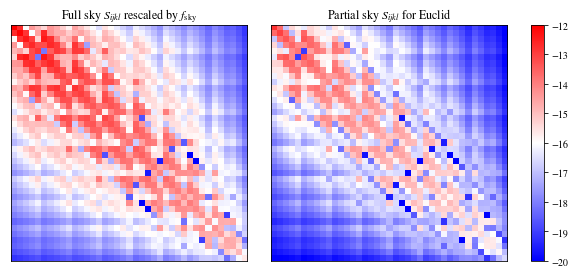

In [49]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(9,4))
im = axes[0].imshow(np.log(abs(Sijkl_full_Euclid_recast_valid/f_sky)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-12)
im2 = axes[1].imshow(np.log(abs(Sijkl_psky_recast_valid)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-12)
for ax in axes:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axes[0].set_title(r'Full sky $S_{ijkl}$ rescaled by $f_\mathrm{sky}$')
axes[1].set_title(r'Partial sky $S_{ijkl}$ for Euclid')
fig.subplots_adjust(left=0.03,bottom=0.08,top=0.9,right=0.83,wspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.08, 0.02, 0.82])
c_bar=fig.colorbar(im,cax=cbar_ax,fraction=.5)

print('Mean ratio of elements of psky to rescaled full sky: %.2f' %(np.mean(Sijkl_psky_recast_valid/(Sijkl_full_Euclid_recast_valid/f_sky))))
print('Mean ratio of diagonal elements of psky to rescaled full sky: %.2f' %(np.mean(np.diag(Sijkl_psky_recast_valid/(Sijkl_full_Euclid_recast_valid/f_sky)))))

## Spectrometry

In [50]:
#GCs
zmins = np.array([0.90,1.10,1.30,1.50])
zmaxs = np.array([1.10,1.30,1.50,1.80])
n_zs = np.array([6.86,5.58,4.21,2.61])* 1e-4
zbins = np.array([1.00,1.20,1.40,1.65])
zmin = np.min(zmins) ; zmax = np.max(zmaxs)
zstakes    = np.r_[zmins,zmaxs[-1]]

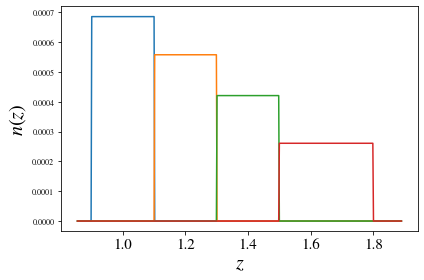

In [51]:
# Define redshift range
nz       = 500
z_arr    = np.linspace(0.95*zmin,zmax*1.05,num=nz)

nbins2   = zmins.size
kernels2 = np.zeros((nbins2,nz))
for i in range(nbins2):
    zminbin = zmins[i] ; zmaxbin = zmaxs[i] ; Dz = zmaxbin-zminbin
    for iz,z in enumerate(z_arr):
        if ((z>zminbin) and (z<=zmaxbin)):
            kernels2[i,iz] = n_zs[i]

plt.figure()
for i in range(nbins2):   
    plt.plot(z_arr,kernels2[i,:])
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$n(z)$',fontsize=20)
plt.xticks(fontsize=15) ; plt.yticks(fontsize=8)
plt.tight_layout()
#plt.savefig(prefix_Euclid+'n_z_Euclid_GCs.png')

In [52]:
# partial sky Sijkl with Euclid mask
t1 = time.process_time()
print('Computing partial sky Sijkl for Euclid...')
Sijkl2 = PySSC.Sijkl_psky(z_arr,kernels2,clmask=None,mask='./masks/Euclid_map_WIDE_SURVEY.fits') 
t2 = time.process_time()
print('Sijkl took %.1f secs' %(t2-t1))

Computing partial sky Sijkl for Euclid...


/tmp/ipykernel_275312/1527118381.py:4: DeprecationWarning: The Sijkl functions are now deprecated. Please move to using Sij by feeding the kernel products, see the documentation at https://pyssc.readthedocs.io/en/latest/notebooks/Main-Examples.html#General-case-with-cross-spectra
  Sijkl2 = PySSC.Sijkl_psky(z_arr,kernels2,clmask=None,mask='./masks/Euclid_map_WIDE_SURVEY.fits')


Sijkl took 27.2 secs


4
0.9 1.8


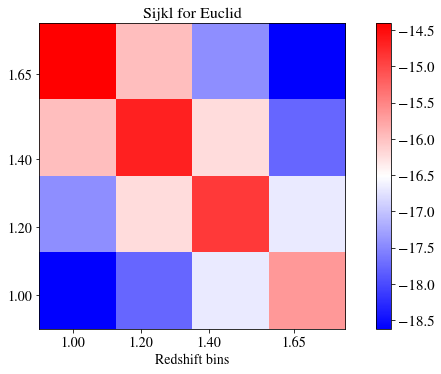

In [53]:
#Build indexing of pairs of redshift bins
npairs = (nbins2*(nbins2+1))//2
pairs  = np.zeros((2,npairs),dtype=int)
count       = 0
for ibin in range(nbins2):
    for jbin in range(ibin,nbins2):
        pairs[0,count] = ibin
        pairs[1,count] = jbin
        count +=1
#Recast Sijkl as a matrix of pairs, for later visualisation
Sijkl_psky_recast2 = np.zeros((npairs,npairs))
for ipair in range(npairs):
    ibin = pairs[0,ipair]
    jbin = pairs[1,ipair]
    for jpair in range(npairs):
        kbin = pairs[0,jpair]
        lbin = pairs[1,jpair]
        Sijkl_psky_recast2[ipair,jpair] = Sijkl2[ibin,jbin,kbin,lbin]

#Remove pairs of bins with zero covariance
invalid_list         = np.where(np.diag(Sijkl_psky_recast2)==0)[0]
Sijkl_psky_recast_valid2 = np.delete(np.delete(Sijkl_psky_recast2,invalid_list,0),invalid_list,1)
nvalid               = Sijkl_psky_recast_valid2.shape[0]
print(nvalid)

fig = plt.figure(figsize=(6.,5)) 
ax = fig.add_axes([0.05,0.1,0.75,0.85]) 
P = ax.imshow(np.log(abs(Sijkl_psky_recast_valid2)),interpolation='none',cmap='bwr',extent=(zmin,zmax,zmin,zmax)) 
plt.xlabel(r'Redshift bins',fontsize=14) 
plt.xticks(zbins,fontsize=14); plt.yticks(zbins,fontsize=14)
ax1 = fig.add_axes([0.85, 0.1, 0.035, 0.85]) 
cbar = plt.colorbar(P,ax1) 
cbar.ax.tick_params(labelsize=15) 
ax.set_title('Sijkl for Euclid',fontsize=16)
print(zmin,zmax)

-0.2445935142619683


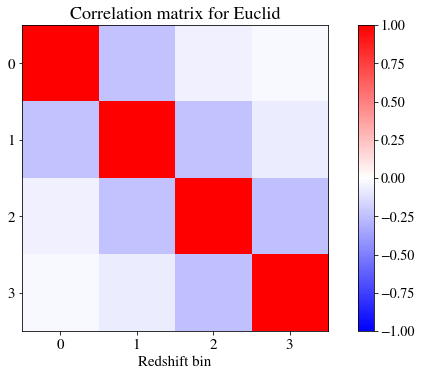

In [54]:
#Second plot the correlation matrix
correl_ijkl_psky2= np.zeros((nvalid,nvalid))
for i in range(nvalid):
    for j in range(nvalid):
        correl_ijkl_psky2[i,j] = Sijkl_psky_recast_valid2[i,j] / np.sqrt(Sijkl_psky_recast_valid2[i,i]*Sijkl_psky_recast_valid2[j,j])

fig = plt.figure(figsize=(6.,5))
ax = fig.add_axes([0.05,0.1,0.75,0.85]) 
#P = ax.imshow(correl_ijkl_psky2,interpolation='none',cmap='bwr',vmin=-1,vmax=1,extent=[zmin,zmax,zmax,zmin])
P = ax.imshow(correl_ijkl_psky2,interpolation='none',cmap='bwr',vmin=-1,vmax=1)
plt.xlabel(r'Redshift bin',fontsize=15) #; plt.ylabel(r'Redshift bin',fontsize=15) 
#plt.xticks(zbins,fontsize=14); plt.yticks(zbins,fontsize=14)
plt.xticks(range(4),fontsize=14); plt.yticks(range(4),fontsize=14)
plt.title('Correlation matrix for Euclid',fontsize=18)
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.85, 0.1, 0.035, 0.85])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=14)
print(correl_ijkl_psky2.min())
#plt.savefig(prefix_Euclid+'Correlation_matrix_Euclid_GCs.png')

## Comparison to flat-sky approximation for 5deg mask

In [55]:
# Top-hat kernels
zstakes   = np.arange(0.2,2.,step=0.1)
zbins     = zstakes[:-1]+(zstakes[1:]-zstakes[:-1])/2
zmin      = np.min(zstakes) ; zmax = np.max(zstakes)
nbins     = zbins.size
nz        = 500
z_arr     = np.linspace(0,2,num=nz+1)[1:] # Redshifts must be > 0
nbins_T   = len(zstakes)-1
kernels_T = np.zeros((nbins_T,nz))
for i in range(nbins_T):
    zminbin = zstakes[i] ; zmaxbin = zstakes[i+1] ; Dz = zmaxbin-zminbin
    for iz in range(nz):
        z = z_arr[iz]
        if ((z>zminbin) and (z<=zmaxbin)):
            kernels_T[i,iz] = 1/Dz

In [57]:
# Full sky Sij
print('Computing full sky Sij')
Sijw_full = PySSC.Sij(z_arr, kernels_T)

Computing full sky Sij


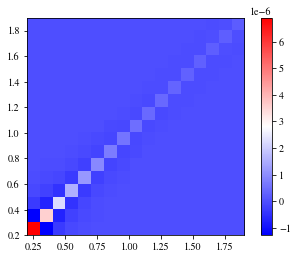

In [58]:
plt.imshow(Sijw_full,origin='lower',extent=(zmin,zmax,zmin,zmax),cmap='bwr')
plt.colorbar()

In [59]:
# Partial sky Sij
print('Computing partial sky Sij')
Sijw_part = PySSC.Sij_psky(z_arr, kernels_T,
                           clmask=None,
                           mask='./masks/mask_circular_5deg2.fits',
                           verbose=False)

Computing partial sky Sij


In [63]:
# Flat-sky approximation
print('Computing flat-sky Sij')
Sij_flat = PySSC.Sij_flatsky(z_arr, kernels_T, bin_centres=zstakes, theta=5.)

Computing flat-sky Sij


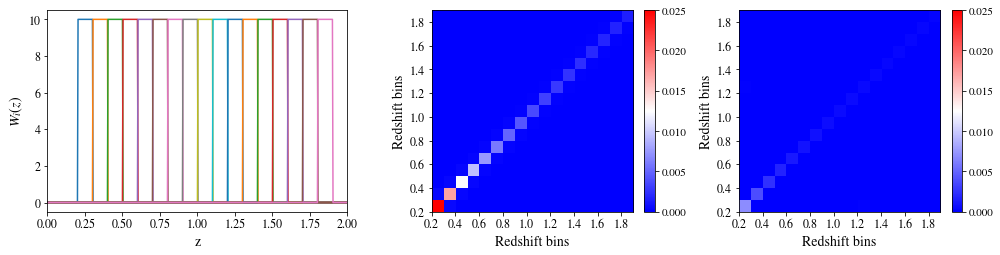

In [102]:
# plot results
fig,axes = plt.subplots(1,3,figsize=(14,3.6),gridspec_kw={'width_ratios':(4,3,3)})
for ibin in range(nbins):   
    axes[0].plot(z_arr,kernels_T[ibin,:])
axes[0].set_xlabel('z',fontsize=14); axes[0].set_ylabel('$W_i(z)$',fontsize=14)
axes[0].tick_params(labelsize=12)
axes[0].set_xlim(0,2)
im = axes[1].imshow(Sijw_part,interpolation='none',cmap='bwr',origin='lower',extent=(zmin,zmax,zmin,zmax),vmin=0,vmax=0.025)
cbar = plt.colorbar(im,ax=axes[1],fraction=0.045); cbar.ax.tick_params(labelsize=11)
im2 = axes[2].imshow(Sij_flat,interpolation='none',cmap='bwr',origin='lower',extent=(zmin,zmax,zmin,zmax),vmin=0,vmax=0.025)
cbar2 = plt.colorbar(im2,ax=axes[2],fraction=0.045); cbar2.ax.tick_params(labelsize=11)
for i in range(1,3):
    axes[i].set_xlabel(r'Redshift bins',fontsize=14); axes[i].set_ylabel(r'Redshift bins',fontsize=14)
    axes[i].set_yticks(zstakes[::2]); axes[i].set_xticks(zstakes[::2])
    axes[i].tick_params(labelsize=12)
fig.tight_layout()
#fig.savefig('flat-sky_5deg.png')

In [103]:
np.mean((np.diag(Sij_flat)-np.diag(Sijw_part))/np.diag(Sijw_part))

-0.8213892922405622

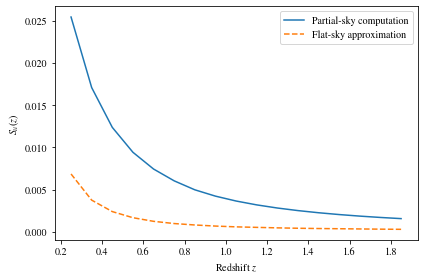

In [104]:
plt.figure()
plt.plot(zbins,np.diag(Sijw_part),label='Partial-sky computation')
plt.plot(zbins,np.diag(Sij_flat),label='Flat-sky approximation',ls='--')
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'$S_{ii}(z)$')
plt.legend()
plt.tight_layout()
# plt.savefig('flat-sky_5deg_diagonal_terms.png')

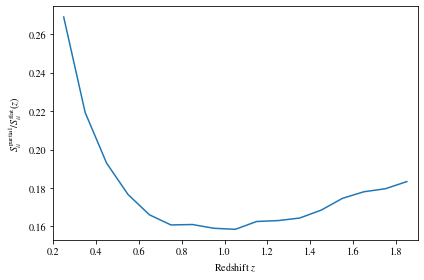

In [105]:
plt.figure()
plt.plot(zbins,np.diag(Sij_flat)/np.diag(Sijw_part))
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'$S_{ii}^\mathrm{partial}/S_{ii}^\mathrm{flat}(z)$')
# plt.legend()
plt.xlim(zmin,zmax)
plt.tight_layout()
# plt.savefig('flat-sky_5deg_ratio_diagonals.png')

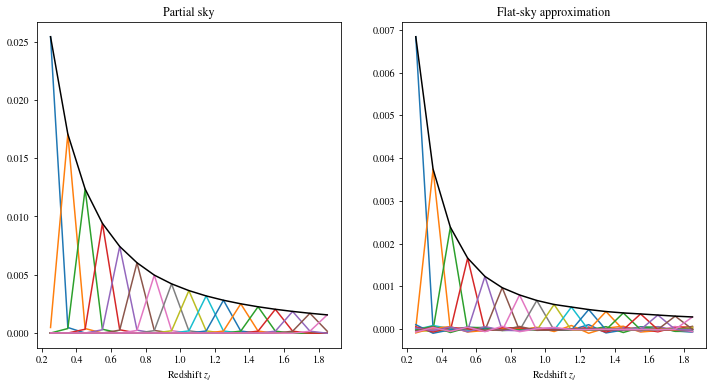

In [106]:
fig,axes = plt.subplots(1,2,figsize=(12,6))
for ibin,zbin in enumerate(zbins):
    axes[0].plot(zbins,Sijw_part[:,ibin],label=r'$z=%.1f$'%zbin)
    axes[1].plot(zbins,Sij_flat[:,ibin],label=r'$z=%.1f$'%zbin)
axes[0].plot(zbins,np.diag(Sijw_part),color='k')
axes[1].plot(zbins,np.diag(Sij_flat),color='k')
axes[0].set_title('Partial sky')
axes[1].set_title('Flat-sky approximation')
for i in range(len(axes)):
    # plt.legend(ncol=3)
    axes[i].set_xlabel(r'Redshift $z_j$')
#     plt.ylabel(r'$S_{ij}(z_i)$')
#     axes[i].set_ylim(bottom=0)
# plt.savefig('flat-sky_5deg_wfs.png')

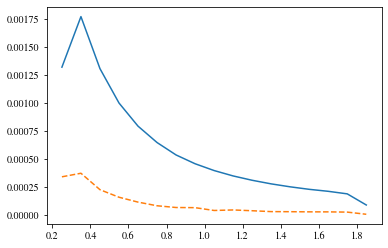

In [107]:
plt.figure()
plt.plot(zbins,[np.trapz(Sijw_part[:,ibin],zbins) for ibin in range(nbins)])
plt.plot(zbins,[np.trapz(Sij_flat[:,ibin],zbins) for ibin in range(nbins)],ls='--')

## Flat-sky approximation for 1deg mask

In [108]:
# Top-hat kernels
zstakes = np.arange(0.2,2.,step=0.1)
zbins = zstakes[:-1]+(zstakes[1:]-zstakes[:-1])/2
zmin = np.min(zstakes) ; zmax = np.max(zstakes)
nbins = zbins.size
nz       = 500
z_arr    = np.linspace(0,2,num=nz+1)[1:] # Redshifts must be > 0
nbins_T   = len(zstakes)-1
kernels_T = np.zeros((nbins_T,nz))
for i in range(nbins_T):
    zminbin = zstakes[i] ; zmaxbin = zstakes[i+1] ; Dz = zmaxbin-zminbin
    for iz in range(nz):
        z = z_arr[iz]
        if ((z>zminbin) and (z<=zmaxbin)):
            kernels_T[i,iz] = 1/Dz

In [109]:
# Partial sky Sij
print('Computing partial sky Sij')
Sijw_part = PySSC.Sij_psky(z_arr, kernels_T,
                           clmask=None,
                           mask='./masks/mask_circular_1deg2.fits',
                           verbose=False)

Computing partial sky Sij


In [110]:
# Flat sky Sij
print('Computing flat sky Sij')
Sij_flat = PySSC.Sij_flatsky(z_arr, kernels_T,
                             bin_centres=zstakes,
                             theta=1.)

Computing flat sky Sij


Text(0, 0.5, 'Redshift bins')

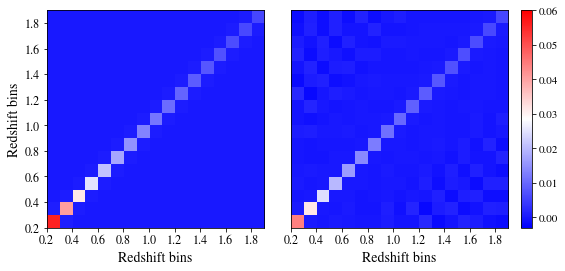

In [111]:
# plot results
fig,axes = plt.subplots(1,2,figsize=(9,4),gridspec_kw={'wspace':0.001})
im = axes[0].imshow(Sijw_part,interpolation='none',cmap='bwr',origin='lower',extent=(zmin,zmax,zmin,zmax),vmin=-0.003,vmax=0.06)
im2 = axes[1].imshow(Sij_flat,interpolation='none',cmap='bwr',origin='lower',extent=(zmin,zmax,zmin,zmax),vmin=-0.003,vmax=0.06)
cbar2 = plt.colorbar(im2,ax=axes[1],fraction=0.045); cbar2.ax.tick_params(labelsize=11)
for i in range(0,len(axes)):
    axes[i].set_xlabel(r'Redshift bins',fontsize=14)
    axes[i].tick_params(labelsize=12)
    axes[i].set_xticks(zstakes[::2])
axes[0].set_yticks(zstakes[::2])
axes[1].set_yticks([])
axes[0].set_ylabel(r'Redshift bins',fontsize=14)
# fig.tight_layout()
#fig.savefig('flat-sky_1deg.png')

In [112]:
np.mean(np.diag(Sij_flat-Sijw_part)[3:]/np.diag(Sijw_part)[3:])

-0.11348141478903111

In [113]:
print(np.diag(Sij_flat))
print(np.diag(Sijw_part))
print(zstakes[3])

[0.04415942 0.0315717  0.02444168 0.01969506 0.01641658 0.01410273
 0.01237261 0.01098162 0.0099172  0.00905789 0.00833785 0.00774376
 0.00724376 0.00680797 0.00642513 0.00609463 0.0058131 ]
[0.05570895 0.04044092 0.03129508 0.02521946 0.02091295 0.01765794
 0.01498254 0.01313485 0.01165963 0.01044306 0.00942104 0.00855161
 0.00780513 0.00715958 0.00659736 0.00610483 0.00567066]
0.5000000000000001


-0.0018551141796715217

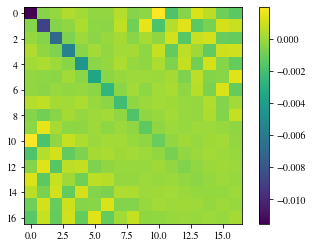

In [114]:
plt.imshow((Sij_flat-Sijw_part))
plt.colorbar()
np.min(Sij_flat)

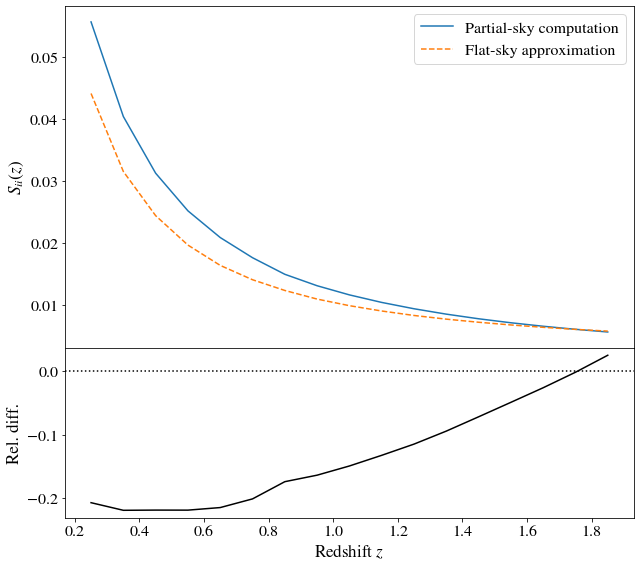

In [115]:
fig,axes = plt.subplots(2,1,figsize=(9,8),sharex=True,gridspec_kw={'hspace':0,'height_ratios':(2,1)})
axes[0].plot(zbins,np.diag(Sijw_part),label='Partial-sky computation')
axes[0].plot(zbins,np.diag(Sij_flat),label='Flat-sky approximation',ls='--')
axes[1].plot(zbins,(np.diag(Sij_flat)-np.diag(Sijw_part))/np.diag(Sijw_part),color='k')
axes[1].axhline(0,color='k',ls=':')
axes[1].set_xlabel(r'Redshift $z$',fontsize=17)
axes[0].set_ylabel(r'$S_{ii}(z)$',fontsize=17)
axes[0].legend(fontsize=16)
for i in range(0,len(axes)):
#     axes[i].set_xlabel(r'Redshift bins',fontsize=14)
    axes[i].tick_params(labelsize=16)
axes[1].set_ylabel(r'Rel. diff.',fontsize=17)
fig.tight_layout()
#plt.savefig('flat-sky_1deg_diagonal_terms.png')

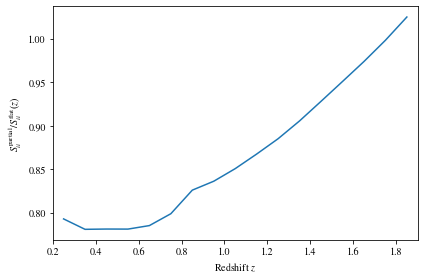

In [116]:
plt.figure()
plt.plot(zbins,np.diag(Sij_flat)/np.diag(Sijw_part))
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'$S_{ii}^\mathrm{partial}/S_{ii}^\mathrm{flat}(z)$')
# plt.legend()
plt.xlim(zmin,zmax)
plt.tight_layout()
# plt.savefig('flat-sky_5deg_ratio_diagonals.png')